In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('../data/creditcard_train.csv')
print('Number of samples: %d' % df.shape[0])
df.head()

Number of samples: 227845


,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,15421,26804.0,0.595160,0.769210,-1.038189,1.042706,0.841673,-0.760026,0.531398,-0.127499,...,-0.164895,-0.283471,-0.332946,-0.465116,1.508018,-0.592311,0.142853,0.267506,-0.350653,0
1,130114,79286.0,0.679454,-1.064142,1.056002,-0.567796,-1.872020,0.131896,-1.579868,0.198040,...,-0.276091,0.136320,-0.072932,0.661767,0.625780,-0.098384,0.239789,0.122947,-0.138095,0
2,242358,151458.0,1.008183,-0.737770,-0.336459,-0.694057,-0.705978,0.009900,-0.875005,0.038105,...,0.694522,1.840101,0.141301,1.280198,-0.429395,-0.267402,0.006912,-0.098442,0.004397,0
3,68887,53179.0,0.655154,-0.065612,0.427128,0.407999,-0.366916,0.036806,-0.385283,0.022864,...,0.001585,0.381711,-0.331094,-0.608447,1.149162,1.381512,-0.001315,0.027879,-0.353869,0
4,76066,56381.0,-0.806131,0.612726,0.044223,0.756445,0.471534,0.720353,-0.736573,-1.772341,...,-1.496771,1.285310,0.284107,-2.155842,-0.037942,-0.226840,0.391020,-0.405597,-0.329483,0


Counts
0    227452
1       393
Name: Class, dtype: int64
Relative counts
0    0.998275
1    0.001725
Name: Class, dtype: float64


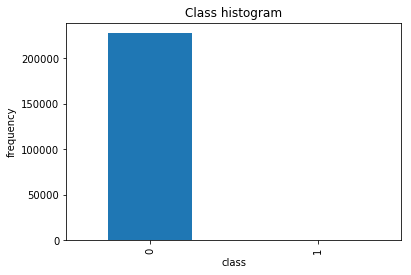

In [3]:
count_classes = pd.value_counts(df['Class'], sort=True).sort_index()
print('Counts')
print(count_classes)
print('Relative counts')
print(count_classes / len(df))
count_classes.plot(kind = 'bar')
plt.title("Class histogram")
plt.xlabel("class")
plt.ylabel("frequency")

In [4]:
from math import floor
from sklearn.utils import shuffle

data = df.drop(['Unnamed: 0', 'Time'], 1).as_matrix()
data = shuffle(data)

x, y = data[:, :-1], data[:, -1]

x0 = x[y == 0]
x1 = x[y == 1]
y0 = y[y == 0]
y1 = y[y == 1]


p = 0.2
idx = len(x0) - floor(p*len(x0))
x0_val, y0_val = x0[idx:], y0[idx:]
x0_train, y0_train = x0[:idx], y0[:idx]

idx = len(x1) - floor(p*len(x1))
x1_val, y1_val = x1[idx:], y1[idx:]
x1_train, y1_train = x1[:idx], y1[:idx]

x_train = np.vstack([x0_train, x1_train])
y_train = np.concatenate([y0_train, y1_train])

x_val = np.vstack([x0_val, x1_val])
y_val = np.concatenate([y0_val, y1_val])

x_train, y_train = shuffle(x_train, y_train)
x_val, y_val = shuffle(x_val, y_val)

np.savez('../data/creditcard_train.npz', x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
print('Fraction of positives in training = %.6f' % y_train.mean())
print('Number of positives in training = %d' % y_train.sum())
print('Fraction of positives in validation = %.6f' % y_val.mean())
print('Number of positives in validation = %d' % y_val.sum())

Fraction of positives in training = 0.001728
Number of positives in training = 315
Fraction of positives in validation = 0.001712
Number of positives in validation = 78


In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, log_loss

import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from keras.regularizers import l2

input_dim = x_train.shape[1]

def logistic_regression(params):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=1, 
              kernel_regularizer=params['regularizer'])(inputs)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'])


    return model

def eval(model, x, y, loss_weights):
    y_score = model.predict(x) 
    y_pred =  y_score > 0.5
    
    if loss_weights is not None:
        weights = np.empty_like(y)
        weights[y == 0] = loss_weights[0]
        weights[y == 1] = loss_weights[1]
    else:
        weights = None
        
    loss = log_loss(y, y_score, 10e-8, sample_weight=weights)
    acc = accuracy_score(y, y_pred)
    recall =  recall_score(y, y_pred)
    precision =  precision_score(y, y_pred)
    auc = roc_auc_score(y, y_score, sample_weight=weights)

    return loss, acc, recall, precision, auc


def log_scores(model, x, y, log_id, scores, loss_weights):
    loss, acc, recall, precision, auc = eval(model, x, y, loss_weights)
    print('\t%s: loss = %.8f, recall = %.6f, precision = %.6f, accuracy = %.6f, auc = %.6f' 
          % (log_id, loss, recall, precision, acc, auc))
    scores['loss'].append(loss)
    scores['acc'].append(acc)
    scores['recall'].append(recall)
    scores['precision'].append(precision)
    scores['auc'].append(auc)


def train(model, epochs, epochs_to_eval):
    scores_train = {
        'loss': [],
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': []
    }
    
    scores_val = {
        'loss': [],
        'acc': [],
        'recall': [],
        'precision': [],
        'auc': []
    }
    
    for epoch in range(0, epochs, epochs_to_eval):
        print('Epoch %d/%d' % (epoch, epochs))
        log_scores(model, x_train, y_train, 'train', scores_train, params['weights'])
        log_scores(model, x_val, y_val, 'valid', scores_val,params['weights'])
        model.fit(x_train, y_train, batch_size=200, verbose=0, epochs=epochs_to_eval, 
                  class_weight=params['weights'])
    
    if 'epoch' not in locals():
        epoch = 0
    else:
        epoch += epochs_to_eval
    
    print('Epoch %d/%d' % (epoch, epochs))
    log_scores(model, x_train, y_train, 'train', scores_train, params['weights'])
    log_scores(model, x_val, y_val, 'valid', scores_val, params['weights'])
    
    return (scores_train, scores_val)


def plot_roc(model, x, y):
    if params['weights'] is not None:
        weights = np.empty_like(y)
        weights[y == 0] = params['weights'][0]
        weights[y == 1] = params['weights'][1]
    else:
        weights = None
        
    y_score = model.predict(x) 
    fpr, tpr, _ = roc_curve(y, y_score, sample_weight=weights)
    roc_auc = roc_auc_score(y, y_score, sample_weight=weights)
    plt.plot(fpr, tpr,label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot(np.arange(0, 1.1, 0.1),np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
def plot_evolution(scores_train, scores_val, metric, loc=None):
    plt.plot(scores_train[metric], label='training')
    plt.plot(scores_val[metric], label='validation')
    plt.xlabel('epoch')
    plt.ylabel(metric)
    if loc is None:
        plt.legend(loc="upper right")
    else:
        plt.legend(loc=loc)

Using TensorFlow backend.


# Always predict anomaly

In [6]:
class EmptyModel(object):
    def __init__(self):
        self.predict = None
        self.fit = None

params = {
    'loss': 'binary_crossentropy',
    'optimizer': Adam(),
    'regularizer': l2(0.),
    'weights': None
}
        
model = EmptyModel()
model.predict = lambda x: np.ones((x.shape[0],))
model.fit = lambda x, y, batch_size, verbose, epochs: 0

_, _ = train(model, 0, 1)

Epoch 0/0
	train: loss = 16.09024134, recall = 1.000000, precision = 0.001728, accuracy = 0.001728, auc = 0.500000
	valid: loss = 16.09050586, recall = 1.000000, precision = 0.001712, accuracy = 0.001712, auc = 0.500000


# Always predict not anomaly

In [7]:
model.predict = lambda x: np.zeros((x.shape[0],))
_, _ = train(model, 0, 1)

Epoch 0/0
	train: loss = 0.02785441, recall = 0.000000, precision = 0.000000, accuracy = 0.998272, auc = 0.500000
	valid: loss = 0.02758989, recall = 0.000000, precision = 0.000000, accuracy = 0.998288, auc = 0.500000


/home/george/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Common logistic regression

In [8]:
model = None
model = logistic_regression(params)
scores_train, scores_val = train(model, 50, 1)

Epoch 0/50
	train: loss = 0.87964522, recall = 0.419048, precision = 0.001524, accuracy = 0.524509, auc = 0.419264
	valid: loss = 0.87599153, recall = 0.384615, precision = 0.001396, accuracy = 0.527980, auc = 0.407987
Epoch 1/50
	train: loss = 0.36460159, recall = 0.809524, precision = 0.704420, accuracy = 0.999084, auc = 0.972013
	valid: loss = 0.36522198, recall = 0.782051, precision = 0.628866, accuracy = 0.998837, auc = 0.935917
Epoch 2/50
	train: loss = 0.20578926, recall = 0.809524, precision = 0.836066, accuracy = 0.999397, auc = 0.981335
	valid: loss = 0.20687918, recall = 0.794872, precision = 0.756098, accuracy = 0.999210, auc = 0.953932
Epoch 3/50
	train: loss = 0.12451263, recall = 0.809524, precision = 0.841584, accuracy = 0.999407, auc = 0.985236
	valid: loss = 0.12574203, recall = 0.794872, precision = 0.765432, accuracy = 0.999232, auc = 0.968152
Epoch 4/50
	train: loss = 0.07914818, recall = 0.800000, precision = 0.854237, accuracy = 0.999418, auc = 0.979466
	valid: l

	valid: loss = 0.00509421, recall = 0.692308, precision = 0.843750, accuracy = 0.999254, auc = 0.973116
Epoch 38/50
	train: loss = 0.00349336, recall = 0.666667, precision = 0.905172, accuracy = 0.999303, auc = 0.986866
	valid: loss = 0.00495864, recall = 0.679487, precision = 0.841270, accuracy = 0.999232, auc = 0.972834
Epoch 39/50
	train: loss = 0.00349449, recall = 0.692063, precision = 0.893443, accuracy = 0.999325, auc = 0.986597
	valid: loss = 0.00504283, recall = 0.666667, precision = 0.838710, accuracy = 0.999210, auc = 0.972023
Epoch 40/50
	train: loss = 0.00348846, recall = 0.688889, precision = 0.900415, accuracy = 0.999331, auc = 0.986868
	valid: loss = 0.00503685, recall = 0.666667, precision = 0.825397, accuracy = 0.999188, auc = 0.972453
Epoch 41/50
	train: loss = 0.00349177, recall = 0.695238, precision = 0.897541, accuracy = 0.999336, auc = 0.986611
	valid: loss = 0.00507372, recall = 0.679487, precision = 0.841270, accuracy = 0.999232, auc = 0.971523
Epoch 42/50
	tra

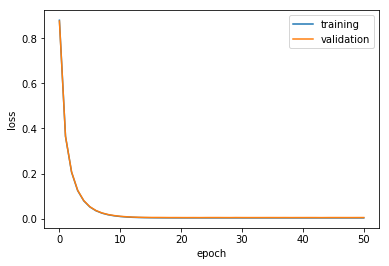

In [9]:
plot_evolution(scores_train, scores_val, 'loss')

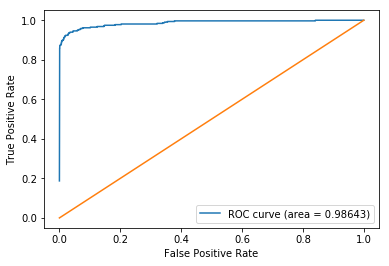

In [10]:
plot_roc(model, x_train, y_train)

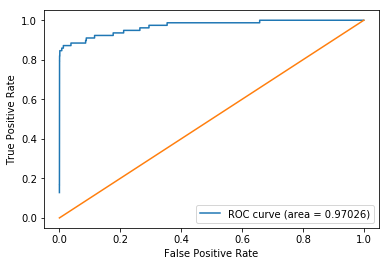

In [11]:
plot_roc(model, x_val, y_val)

# Logistic regression: weighted labels with class frequency

In [12]:
params = {
    'loss': 'binary_crossentropy',
    'optimizer': Adam(),
    'regularizer': l2(0.),
    'weights': {0:len(y_train) / np.sum(1 - y_train), 1:len(y_train) / np.sum(y_train)}
}

model = None
model = logistic_regression(params)

print('Weights: %s', params['weights'])
scores_train1, scores_val1 = train(model, 100, 1)

Weights: %s {0: 1.0017311306756356, 1: 578.65714285714284}
Epoch 0/100
	train: loss = 1.69030210, recall = 0.422222, precision = 0.001479, accuracy = 0.506219, auc = 0.420716
	valid: loss = 1.54908022, recall = 0.435897, precision = 0.001511, accuracy = 0.505815, auc = 0.441276
Epoch 1/100
	train: loss = 0.44776834, recall = 0.926984, precision = 0.004315, accuracy = 0.630233, auc = 0.923760
	valid: loss = 0.41601285, recall = 0.935897, precision = 0.004314, accuracy = 0.630179, auc = 0.934595
Epoch 2/100
	train: loss = 0.31823795, recall = 0.933333, precision = 0.008046, accuracy = 0.801039, auc = 0.951491
	valid: loss = 0.31683703, recall = 0.923077, precision = 0.007851, accuracy = 0.800189, auc = 0.952516
Epoch 3/100
	train: loss = 0.24881962, recall = 0.923810, precision = 0.019164, accuracy = 0.918158, auc = 0.961904
	valid: loss = 0.26027782, recall = 0.871795, precision = 0.017867, accuracy = 0.917749, auc = 0.959505
Epoch 4/100
	train: loss = 0.20822586, recall = 0.920635, pre

Epoch 37/100
	train: loss = 0.12014856, recall = 0.936508, precision = 0.068701, accuracy = 0.977951, auc = 0.989471
	valid: loss = 0.17474341, recall = 0.884615, precision = 0.062956, accuracy = 0.977265, auc = 0.978814
Epoch 38/100
	train: loss = 0.12001078, recall = 0.933333, precision = 0.067695, accuracy = 0.977671, auc = 0.989502
	valid: loss = 0.17480503, recall = 0.884615, precision = 0.062500, accuracy = 0.977089, auc = 0.978857
Epoch 39/100
	train: loss = 0.11997751, recall = 0.933333, precision = 0.066925, accuracy = 0.977397, auc = 0.989406
	valid: loss = 0.17516467, recall = 0.884615, precision = 0.061939, accuracy = 0.976870, auc = 0.978907
Epoch 40/100
	train: loss = 0.11984841, recall = 0.933333, precision = 0.068198, accuracy = 0.977847, auc = 0.989426
	valid: loss = 0.17486747, recall = 0.884615, precision = 0.062443, accuracy = 0.977067, auc = 0.978967
Epoch 41/100
	train: loss = 0.11974389, recall = 0.933333, precision = 0.066894, accuracy = 0.977386, auc = 0.989476

	valid: loss = 0.17426678, recall = 0.884615, precision = 0.061773, accuracy = 0.976804, auc = 0.979194
Epoch 75/100
	train: loss = 0.11799509, recall = 0.933333, precision = 0.067047, accuracy = 0.977441, auc = 0.989816
	valid: loss = 0.17449537, recall = 0.884615, precision = 0.061552, accuracy = 0.976716, auc = 0.979199
Epoch 76/100
	train: loss = 0.11797635, recall = 0.933333, precision = 0.067664, accuracy = 0.977660, auc = 0.989824
	valid: loss = 0.17451827, recall = 0.884615, precision = 0.062274, accuracy = 0.977001, auc = 0.979276
Epoch 77/100
	train: loss = 0.11795944, recall = 0.933333, precision = 0.069405, accuracy = 0.978258, auc = 0.989823
	valid: loss = 0.17486596, recall = 0.871795, precision = 0.063670, accuracy = 0.977835, auc = 0.979234
Epoch 78/100
	train: loss = 0.11794236, recall = 0.933333, precision = 0.066955, accuracy = 0.977408, auc = 0.989879
	valid: loss = 0.17446661, recall = 0.884615, precision = 0.061552, accuracy = 0.976716, auc = 0.979262
Epoch 79/100

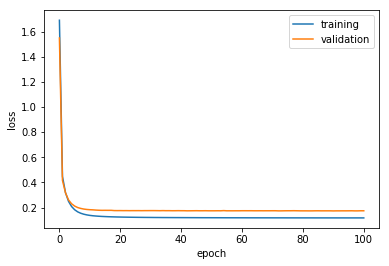

In [13]:
plot_evolution(scores_train1, scores_val1, 'loss')

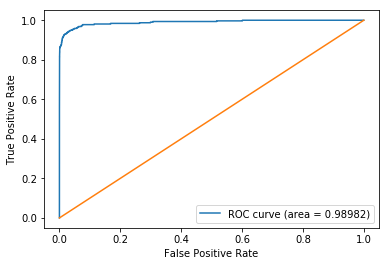

In [14]:
plot_roc(model, x_train, y_train)

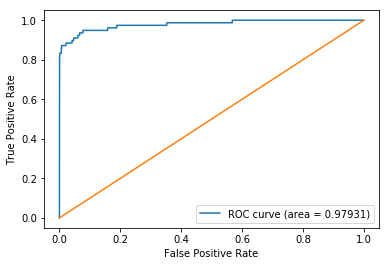

In [15]:
plot_roc(model, x_val, y_val)